In [1]:
!pip install \
    matplotlib \
    pandas \
    tqdm \
    ipywidgets \
    opencv-python

     |████████████████████████████████| 11.6 MB 101 kB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 50.4 MB 88 kB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 921 kB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 873 kB/s eta 0:00:01
     |████████████████████████████████| 15.4 MB 748 kB/s eta 0:00:01


In [11]:
import math
import random
import textwrap
import typing as t

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
!ls -la /data

total 6720
drwxrwxr-x 5 jovyan  1000    4096 Mar 25 08:08 .
drwxr-xr-x 1 root   root     4096 Mar 25 08:09 ..
-rw-rw-r-- 1 jovyan  1000     115 Jan 12 21:00 sample_submission.csv
-rw-rw-r-- 1 jovyan  1000     456 Jan 12 21:00 test.csv
drwxrwxr-x 2 jovyan  1000    4096 Mar 23 18:40 test_images
-rw-rw-r-- 1 jovyan  1000 4752124 Jan 12 21:00 train.csv
drwxrwxr-x 2 jovyan  1000 2097152 Mar 23 18:40 train_images
drwxr-sr-x 2 jovyan users    4096 Mar 24 17:52 wheels


In [2]:
train_df = pd.read_csv('/data/train.csv')

In [3]:
len(train_df)

34250

In [4]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [5]:
len(train_df.label_group.unique())

11014

  0%|          | 0/34250 [00:00<?, ?it/s]

  0%|          | 0/11014 [00:00<?, ?it/s]

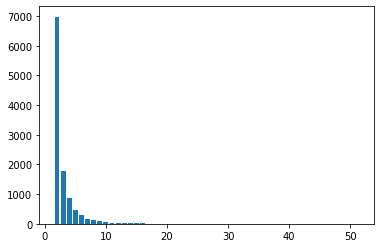

In [8]:
# Get num samples per label_group distribution

def _cell():
    samples_per_label_group_map = {}
    for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
        label_group = row['label_group']
        samples_per_label_group_map[label_group] = samples_per_label_group_map.get(label_group, 0) + 1

    sample_freq_map = {}
    for _, num_samples in tqdm(samples_per_label_group_map.items(), total=len(samples_per_label_group_map)):
        sample_freq_map[num_samples] = sample_freq_map.get(num_samples, 0) + 1
    
    sample_freq_tuple_list = sorted(sample_freq_map.items(), key=lambda x: x[0])
    plt.bar([x[0] for x in sample_freq_tuple_list], [x[1] for x in sample_freq_tuple_list])

_cell()

Total samples: 2


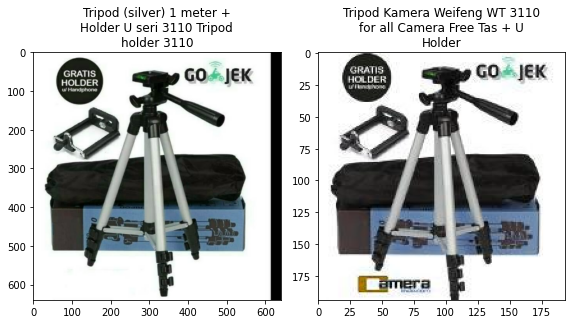

In [29]:
# Look at the images and titles of a given label_group

def _cell():
    images_per_row = 3
    figsize = (12, 12)
    
    lg = random.choice(train_df.label_group.unique())
    lg_df = train_df[train_df.label_group == lg]
    print(f'Total samples: {len(lg_df)}')
    fig, axarr = plt.subplots(math.ceil(len(lg_df) / images_per_row), images_per_row, figsize=figsize)
    title_list = []
    
    last_col = 0
    for i, (_, row) in enumerate(lg_df.iterrows()):
        img = cv2.imread('/data/train_images/' + row['image'])
        if len(axarr.shape) > 1:
            ax = axarr[i // images_per_row, i % images_per_row]
        else:
            ax = axarr[i % images_per_row]
        last_col = i % images_per_row
        ax.imshow(img)
        ax.set_title('\n'.join(textwrap.wrap(row['title'], 30)))
    for i in range(last_col + 1, images_per_row):
        if len(axarr.shape) > 1:
            fig.delaxes(axarr[len(lg_df) // images_per_row, i])
        else:
            fig.delaxes(axarr[i])
    fig.tight_layout()

_cell()

In [6]:
# Split train_df to train and test sets.

def _cell():
    test_set_size = 0.3
    
    lg_list = train_df.label_group.unique().tolist()
    n_test = round(len(lg_list) * 0.3)
    n_train = len(lg_list) - n_test
    random.shuffle(lg_list)
    train_lg_list = lg_list[:n_train]
    test_lg_list = lg_list[n_train:]
    
    train_set_df = train_df[train_df.label_group.isin(train_lg_list)]
    test_set_df = train_df[train_df.label_group.isin(test_lg_list)]
    
    train_set_df.to_csv('/data/train-set.csv')
    test_set_df.to_csv('/data/test-set.csv')
    
    return train_set_df, test_set_df

train_set_df, test_set_df = _cell()

In [19]:
test_set_df.sample(n=1).to_dict('records')[0]

{'posting_id': 'train_4196934799',
 'image': '62968e790fc0ff9e302d047d023f8b6c.jpg',
 'image_phash': '8f0ef0f81d0f940f',
 'title': 'Mukena Tazbiya Artline Roses Grey',
 'label_group': 3241981495}

In [20]:
# Generate test set pairs for deterministic evaluation

def _cell():
    def get_pair_list(val_set: t.Set[str]) -> t.List[t.Tuple[str, str]]:
        pairs: t.List[t.Tuple[str, str]] = []
        for v1 in val_set:
            for v2 in val_set:
                if v1 != v2 and (v1, v2) not in pairs and (v2, v1) not in pairs:
                    pairs.append((v1, v2))
        return pairs
    
    def merge_rows(
            r1: t.Dict[str, t.Union[int, str]],
            r2: t.Dict[str, t.Union[int, str]]) -> t.Dict[str, t.Union[int, str]]:
        return {
            'posting_id_1': r1['posting_id'],
            'posting_id_2': r2['posting_id'],
            'image_1': r1['image'],
            'image_2': r2['image'],
            'title_1': r1['title'],
            'title_2': r2['title'],
            'label_group_1': r1['label_group'],
            'label_group_2': r2['label_group'],
        }
    
    def generate_pairs(df: pd.DataFrame) -> pd.DataFrame:
        pair_list_dict: t.List[t.Dict[str, t.Union[int, str]]] = []
        lg_set: t.Set[int] = set(df.label_group.unique().tolist())
        for lg in tqdm(lg_set):
            posting_id_set = set(df[df.label_group == lg].posting_id.unique().tolist())
            for pid1, pid2 in get_pair_list(posting_id_set):
                row1 = df[df.posting_id == pid1].to_dict('records')[0]
                row2 = df[df.posting_id == pid2].to_dict('records')[0]
                row3 = df[df.label_group != lg].sample(n=1).to_dict('records')[0]
                pair_list_dict.append(merge_rows(row1, row2))
                pair_list_dict.append(merge_rows(row1, row3))
        return pd.DataFrame(pair_list_dict)
    
    test_pair_df = generate_pairs(test_set_df)
    test_pair_df.to_csv('/data/test_pairs.csv')
    return test_pair_df

test_pair_df = _cell()

  0%|          | 0/3304 [00:00<?, ?it/s]

In [25]:
# Generate test set triplets for deterministic evaluation

def _cell():
    def get_pair_list(val_set: t.Set[str]) -> t.List[t.Tuple[str, str]]:
        pairs: t.List[t.Tuple[str, str]] = []
        for v1 in val_set:
            for v2 in val_set:
                if v1 != v2 and (v1, v2) not in pairs:
                    pairs.append((v1, v2))
        return pairs
    
    def merge_rows(
            ra: t.Dict[str, t.Union[int, str]],
            rp: t.Dict[str, t.Union[int, str]],
            rn: t.Dict[str, t.Union[int, str]]) -> t.Dict[str, t.Union[int, str]]:
        return {
            'posting_id_a': ra['posting_id'],
            'posting_id_p': rp['posting_id'],
            'posting_id_n': rn['posting_id'],
            'image_a': ra['image'],
            'image_p': rp['image'],
            'image_n': rn['image'],
            'title_a': ra['title'],
            'title_p': rp['title'],
            'title_n': rn['title'],
            'label_group_a': ra['label_group'],
            'label_group_p': rp['label_group'],
            'label_group_n': rn['label_group'],
        }
    
    def generate_pairs(df: pd.DataFrame) -> pd.DataFrame:
        triplet_list_dict: t.List[t.Dict[str, t.Union[int, str]]] = []
        lg_set: t.Set[int] = set(df.label_group.unique().tolist())
        for lg in tqdm(lg_set):
            posting_id_set = set(df[df.label_group == lg].posting_id.unique().tolist())
            for pid_a, pid_p in get_pair_list(posting_id_set):
                row_a = df[df.posting_id == pid_a].to_dict('records')[0]
                row_p = df[df.posting_id == pid_p].to_dict('records')[0]
                row_n = df[df.label_group != lg].sample(n=1).to_dict('records')[0]
                triplet_list_dict.append(merge_rows(row_a, row_p, row_n))
        return pd.DataFrame(triplet_list_dict)
    
    test_triplet_df = generate_pairs(test_set_df)
    test_triplet_df.to_csv('/data/test_triplets.csv')
    return test_triplet_df

test_triplet_df = _cell()

  0%|          | 0/3304 [00:00<?, ?it/s]

In [26]:
len(test_triplet_df)

52090